# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate synthetic data

In [5]:
from VAETransformer_FCGPFA import get_K
### Generate data
torch.manual_seed(1)
np.random.seed(1)

MAX_FIRING_RATE = 10
gt_neuron_params = {'baseline_fr':0.05, 'ntrial':2000, 'narea':2, 'nneuron_area':50, 
                    'nt':250, 'npadding':50}
gt_latent_params = {'sigma2':0.5, 'nlatent':2, 'offset':0.0, 'L':150}
coupling_filter_params = {'peaks_max':7, 'num':3, 'nonlinear':0.5}
self_history_filter_params = {'peaks_max':2, 'num':3, 'nonlinear':0.7}
nfactor_baseline = gt_latent_params['nlatent']
connections = [{'send':0, 'receive':1, 
                'strength': np.array([[1.0,0.0],[0.2,0.0],[0.0,0.0]]),
                'nneuron_involved': 10}]
history_filter_coefficients = np.array([-2, -1, 0.2])[:, np.newaxis]

ntrial = gt_neuron_params['ntrial']
nneuron = gt_neuron_params['narea']*gt_neuron_params['nneuron_area']
nneuron_area = gt_neuron_params['nneuron_area']
narea = gt_neuron_params['narea']
basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
basis_self_history_temp = GLM.make_pillow_basis(**self_history_filter_params)
basis_self_history = np.zeros((basis_coupling.shape[0], basis_self_history_temp.shape[1]))
basis_self_history[:basis_self_history_temp.shape[0], :] = basis_self_history_temp
max_histories, nbasis = basis_coupling.shape
nt = gt_neuron_params['nt'] + gt_neuron_params['npadding']
nfactor_coupling_tot = sum([conn['strength'].shape[1] for conn in connections])

baseline_mat = np.ones((nt, nneuron, ntrial))*np.log(gt_neuron_params['baseline_fr'])
spikes = np.zeros((nt, nneuron, ntrial))
log_firing_rate_rcd = np.zeros((nt, nneuron, ntrial))
factor_coupling = np.zeros((nt, nfactor_coupling_tot, ntrial))
factor_baseline_rcd = np.zeros((nt, nfactor_baseline, ntrial, narea))

# Prepare loading_mat_baseline
loading_mat_baseline_list = [np.zeros((nneuron_area, nfactor_baseline)) for _ in range(narea)]
for jarea in range(narea):
    loading_mat_baseline_list[jarea] = (
        np.random.uniform(low=-0.9, high=1.0, size=(nneuron_area, nfactor_baseline))
    )

# Prepare baseline_mat
for jarea in range(narea):
    K_gt = get_K(nt=nt, L=gt_latent_params['L'], sigma2=gt_latent_params['sigma2'])
    factor_baseline = np.random.multivariate_normal(
        np.zeros(nt), K_gt, (ntrial, nfactor_baseline)
    ).transpose(2, 1, 0) # nt x nlatent x ntrial
    baseline_mat[:, jarea*nneuron_area:(jarea+1)*nneuron_area, :] += (
        np.einsum('nf, tfm -> tnm', loading_mat_baseline_list[jarea], factor_baseline)
    )
    factor_baseline_rcd[:, :, :, jarea] = factor_baseline

# Prepare coupling_mat
readin_mat_coupling = np.zeros((nneuron, nfactor_coupling_tot))
coupling_mat = np.zeros((max_histories, nneuron, nfactor_coupling_tot))
loading_mat_coupling = np.zeros((nneuron, nfactor_coupling_tot))
nfactor_coupling_counter = 0
for i, connection in enumerate(connections):
    nneuron_involved = connection['nneuron_involved']
    nfactor_coupling = connection['strength'].shape[1]
    temp = np.random.uniform(low=0.8, high=1.2, size=(nneuron_involved, nfactor_coupling))
    temp /= np.linalg.norm(temp, axis=0)[np.newaxis, :]
    readin_mat_coupling[
        connection['send']*nneuron_area:connection['send']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = temp
    coupling_mat[
        :, 
        connection['send']*nneuron_area:connection['send']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = (basis_coupling @ connection['strength'])[::-1, np.newaxis, :]
    coupling_mat *= readin_mat_coupling[np.newaxis, :, :]
    temp = np.random.uniform(low=0.8, high=1.2, size=(nneuron_involved, nfactor_coupling))
    temp /= np.linalg.norm(temp, axis=0)[np.newaxis, :]
    loading_mat_coupling[
        connection['receive']*nneuron_area:connection['receive']*nneuron_area+nneuron_involved,
        nfactor_coupling_counter:nfactor_coupling_counter+nfactor_coupling
    ] = temp
    nfactor_coupling_counter += nfactor_coupling

# Prepare self-history matrix
history_filter = (basis_self_history @ history_filter_coefficients).squeeze()[::-1]
history_mat = np.zeros((len(history_filter), nneuron, nneuron))
for i in range(nneuron):
    history_mat[:,i,i] = history_filter

# Generate spikes
for itrial in tqdm(range(ntrial)):
    spikes_single_trial = np.zeros((nt, nneuron, 1))
    log_firing_rate = copy.copy(baseline_mat[:,:,itrial:itrial+1])
    spikes_single_trial[0,:,0] = np.random.poisson(np.exp(log_firing_rate[0,:, 0]))

    for t in range(1, nt):
        nhistories = min(t, max_histories)
        factor_coupling_single = (coupling_mat[-nhistories:, :, :] \
                * spikes_single_trial[(t-nhistories):(t), :, :]).sum(axis=(0, 1))
        factor_coupling[t,:,itrial] = factor_coupling_single
        log_firing_rate[t,:,0] += (loading_mat_coupling @ factor_coupling_single[:, np.newaxis]).squeeze()
        history = (history_mat[-nhistories:, :, :] \
            * spikes_single_trial[(t-nhistories):(t), :, :]).sum(axis=(0, 1))
        log_firing_rate[t,:,0] += history
        log_firing_rate[t,:,0] = np.minimum(log_firing_rate[t,:,0], MAX_FIRING_RATE)
        spikes_single_trial[t,:,0] = np.random.poisson(np.exp(log_firing_rate[t,:,0]))
        # spikes_single_trial[t,:,0] = np.exp(log_firing_rate[t,:,0])

    log_firing_rate = log_firing_rate.squeeze()
    spikes_single_trial = spikes_single_trial.squeeze()
    spikes[:, :, itrial] = spikes_single_trial
    log_firing_rate_rcd[:, :, itrial] = log_firing_rate

spikes_area = [spikes[:,iarea*nneuron_area:(iarea+1)*nneuron_area,:] for iarea in range(narea)]

100%|██████████| 2000/2000 [01:55<00:00, 17.30it/s]


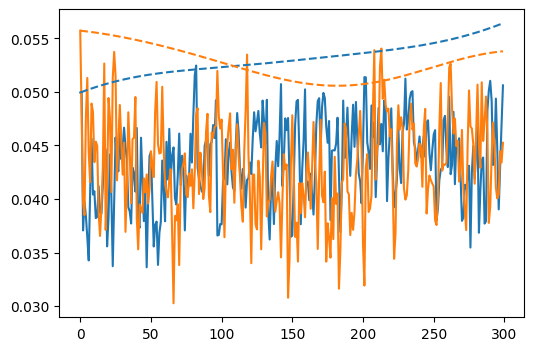

In [6]:
plt.figure(figsize=(6,4))
trials_to_plot = 1

for trial in range(trials_to_plot):  # Plot first 20 trials
    # Get mean across neurons for this trial
    pop1_mean = np.exp(log_firing_rate_rcd[:,:gt_neuron_params["nneuron_area"],trial].mean(axis=1))
    pop2_mean = np.exp(log_firing_rate_rcd[:,gt_neuron_params["nneuron_area"]:,trial].mean(axis=1))
    pop1_baseline = np.exp(baseline_mat[:,:gt_neuron_params["nneuron_area"],trial].mean(axis=1))
    pop2_baseline = np.exp(baseline_mat[:,gt_neuron_params["nneuron_area"]:,trial].mean(axis=1))
    plt.plot(pop1_mean, '-', color='tab:blue')
    plt.plot(pop2_mean, '-', color='tab:orange')
    plt.plot(pop1_baseline, '--', color='tab:blue')
    plt.plot(pop2_baseline, '--', color='tab:orange')


In [7]:
spikes.mean(axis=0).max()*500/1000

0.21333333333333335

Text(0.5, 1.0, 'Spike raster for neuron 52')

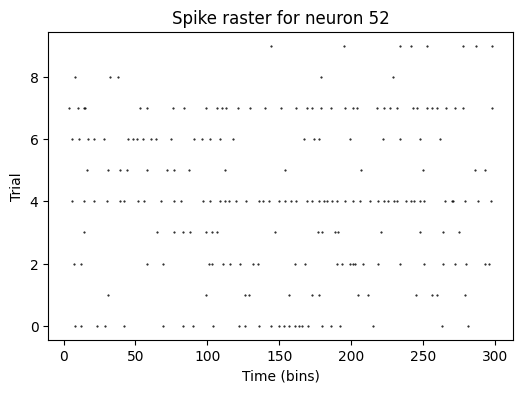

In [8]:
# Plot raster for one example neuron
neuron_idx = gt_neuron_params['nneuron_area']+2  # Choose first neuron
plt.figure(figsize=(6,4))
for trial in range(10):  # Plot first 200 trials
    spike_times = np.where(spikes[:,neuron_idx,trial])[0]
    plt.plot(spike_times, trial*np.ones_like(spike_times), '.', markersize=1, color='black')
plt.xlabel('Time (bins)')
plt.ylabel('Trial')
plt.title(f'Spike raster for neuron {neuron_idx}')


In [9]:
nneuron = spikes.shape[1]//2

synthetic_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron,:], spikes[:,nneuron:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

# Train a model

In [10]:
FIT_THE_BASELINE_MODEL = False
verbose = False

# data_to_use = cross_session_dataloader
data_to_use = synthetic_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint_GLM_gt'

params = {
    # B-spline basis
    'num_B_spline_basis': 50,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 1,
    'transformer_d_model': 512,
    'transformer_dim_feedforward': 2048,
    'transformer_vae_output_dim': 128,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 4,
    'stimulus_decoder_inter_dim_factor': 4,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 7,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Self-history's settings
    'self_history_basis_peaks_max': 2,
    'self_history_basis_num': 3,
    'self_history_basis_nonlinear': 0.7,
    # Penalty settings
    'penalty_smoothing_spline': None,
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    'penalty_loading_similarity': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
    'lr_self_history': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)

if FIT_THE_BASELINE_MODEL:
    # Baseline model: no trial-varying stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        include_self_history=True,
        fix_stimulus=True,
        fix_latents=True,
        verbose=verbose,
    )

else:
    # First step: train the model with a trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        include_self_history=False,
        fix_stimulus=True,
        fix_latents=True,
        verbose=verbose,
    )
    # Second step: train the model with a trial-varying stimulus effect
    # trainer.make_optimizer(frozen_params=['sti_readout'])
    trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        include_self_history=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=verbose,
    )

    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        include_self_history=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=verbose,
    )

    # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
        'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
        'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        include_self_history=True,
        fix_stimulus=False,
        fix_latents=True,
        verbose=verbose,
    )



/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda


  6%|▋         | 13/200 [00:03<00:48,  3.84it/s]
/home/qix/FC-GPFA/model_trainer.py:316: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(

In [11]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader
plot_neuron = 0
plot_trial = 0

###
trainer.model.normalize_coupling_coefficients()
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 142.17it/s]

Test loss: 0.1987935948624575
Test loss baseline: 0.2101161103519121


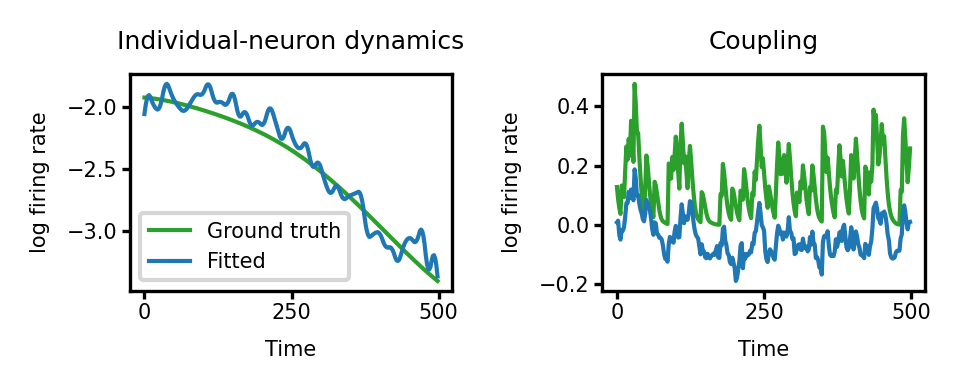

In [23]:
local_trial_indices = np.arange(0, 1)
neuron_idx = gt_neuron_params['nneuron_area']+2

utils.use_pdf_plot()

firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices, spike_train_test = trainer.predict(
    dataset='test',
    batch_indices=[0],
    include_stimulus=True,
    include_coupling=True,
    include_self_history=True,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=True,
    return_spike_trains=True,
)

xx = np.arange(firing_rate_test.shape[0]) * 2
fig, axes = plt.subplots(1, 2, figsize=(3.3, 1.4), dpi=300)

for trial_idx in local_trial_indices:
    # Plot ground truth
    axes[0].plot(
        xx,
        baseline_mat[gt_neuron_params['npadding']:, neuron_idx, trial_indices[trial_idx]],
        color=f'tab:green',  # Match color with predicted
        label=f'Ground truth',
        lw=1,
    )
    # Plot predicted
    axes[0].plot(
        xx,
        trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy(),
        color=f'tab:blue',  # Use matplotlib default color cycle
        label=f'Fitted',
        lw=1,
    )
axes[0].set_title('Individual-neuron dynamics')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('log firing rate')
axes[0].set_xticks([0, 250, 500])
# Add legend for the first pair only
axes[0].legend()


# Plot coupling factor
for trial_idx in local_trial_indices:
    gt_coupling_effect = (loading_mat_coupling[:, 0:1] @ factor_coupling[:, 0, trial_indices[trial_idx]][np.newaxis, :]).T
    # Plot ground truth
    axes[1].plot(
        xx,
        gt_coupling_effect[gt_neuron_params['npadding']:, neuron_idx],
        color=f'tab:green',  # Match color with predicted
        label=f'Ground truth',
    )
    # Plot predicted
    axes[1].plot(
        xx,
        trainer.model.coupling_outputs[0][1][trial_idx, neuron_idx-gt_neuron_params['nneuron_area'], :].cpu().numpy(),
        color=f'tab:blue',  # Use matplotlib default color cycle
        label=f'Fitted',
    )


axes[1].set_title('Coupling')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('log firing rate')
axes[1].set_xticks([0, 250, 500])

plt.tight_layout()
plt.savefig('Figure/SupFigure_failed_case.pdf', bbox_inches='tight', dpi=300)

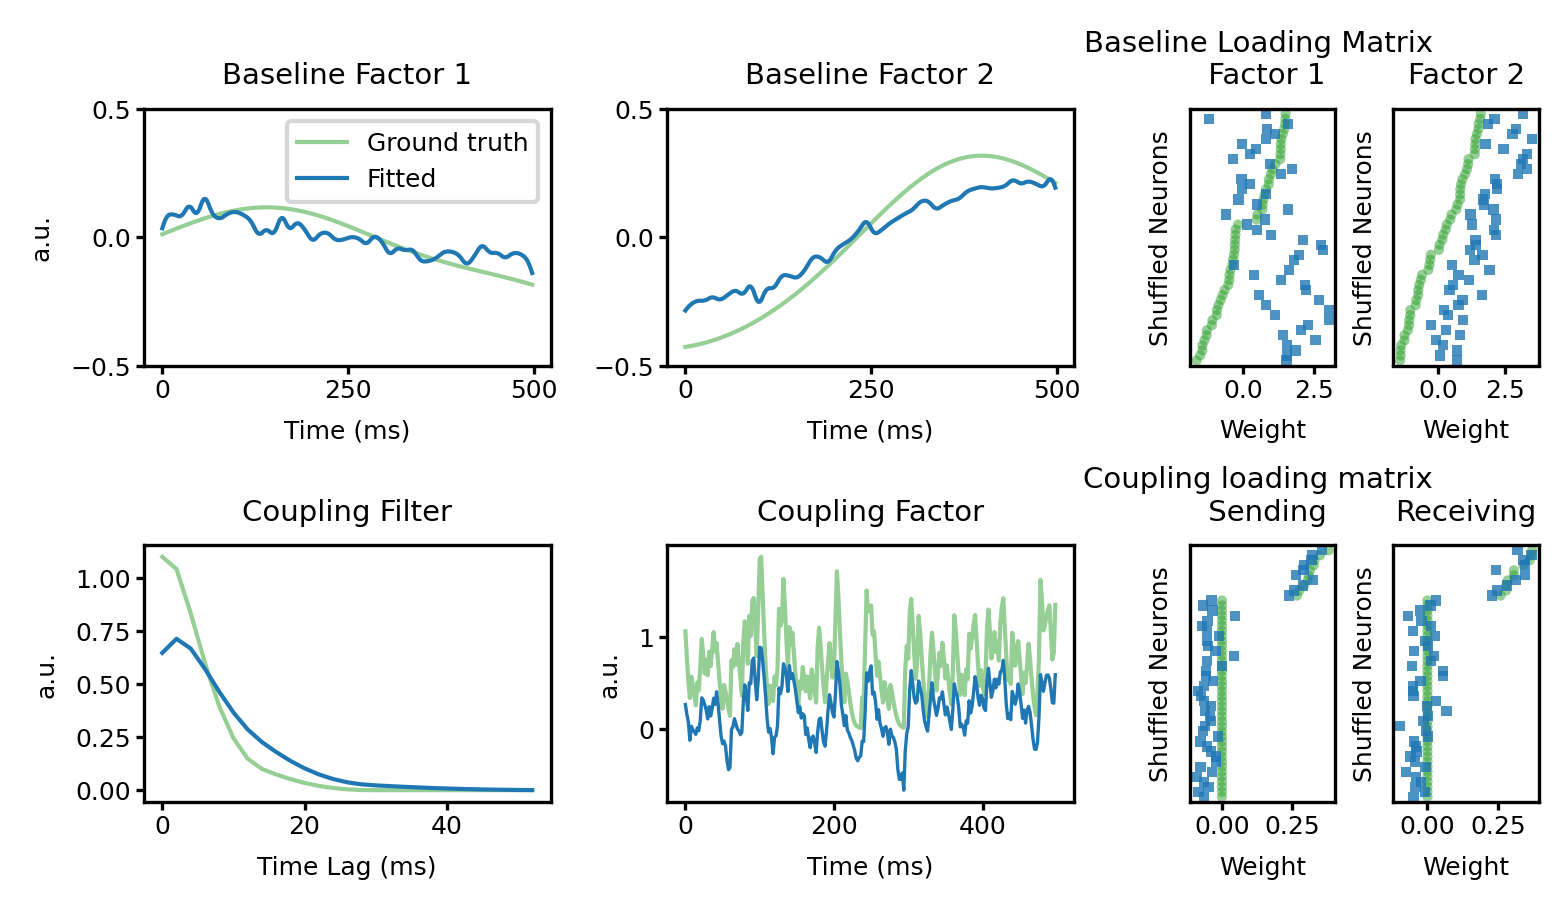

In [64]:
# Create 2x3 subplot
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(6, 3), dpi=300)
outer = GridSpec(2, 3, figure=fig, wspace=0.3, hspace=0.7, width_ratios=[0.35, 0.35, 0.3])
axes = np.empty((2, 3), dtype=object)
for i in range(2):
    for j in range(3):
        if (i, j) not in [(0, 2), (1, 2)]:  # we'll manually insert subpanels here
            axes[i, j] = fig.add_subplot(outer[i, j])

# Pick a trial with intermediate fit (using middle trial)
local_trial_idx = utils.find_middle_fit_trial(
    firing_rate_test, 
    spike_train_test,
    left_and_right_trials=1
)[0]
global_trial_idx = trial_indices[local_trial_idx]
plot_area = 1
xx = np.arange(firing_rate_test.shape[0])*2

### First row - Baseline components
# Normalize both the ground truth and the fitted
readout_mat_fitted = trainer.model.sti_readout_matrix_dict["0"][plot_area].weight.detach().cpu().numpy()
readout_mat_gt = loading_mat_baseline_list[plot_area]
fitted_rescale = np.std(readout_mat_fitted, axis=0)*np.sign(readout_mat_fitted.mean(axis=0))
gt_rescale = np.std(readout_mat_gt, axis=0)*np.sign(readout_mat_gt.mean(axis=0))
npadding = gt_neuron_params['npadding']

# Baseline Factor 1
axes[0,0].plot(
    xx,
    utils.centralize_factor(
        factor_baseline_rcd[npadding:, 0, global_trial_idx, plot_area]
    *gt_rescale[0]),
    label='Ground truth', color='tab:green', alpha=0.5
)
axes[0,0].plot(
    xx,
    utils.centralize_factor(
       trainer.model.factors[local_trial_idx,plot_area,:,1].detach().cpu().numpy()
    *fitted_rescale[1]),
    label='Fitted', color='tab:blue'
)
axes[0,0].set_title('Baseline Factor 1')
axes[0,0].set_xlabel('Time (ms)')
axes[0,0].set_ylabel('a.u.')
axes[0,0].legend()
axes[0,0].set_ylim(-0.5, 0.5)
axes[0,0].set_xticks([0, 250, 500])
axes[0,0].set_yticks([-0.5, 0, 0.5])

# Baseline Factor 2
axes[0,1].plot(
    xx,
    utils.centralize_factor(
        factor_baseline_rcd[npadding:, 1, global_trial_idx, plot_area]
    *gt_rescale[1]),
    label='Ground truth', color='tab:green', alpha=0.5,
)
axes[0,1].plot(
    xx,
    utils.centralize_factor(
        trainer.model.factors[local_trial_idx,plot_area,:,0].detach().cpu().numpy()
    *fitted_rescale[0]),
    label='Fitted', color='tab:blue',
)
axes[0,1].set_title('Baseline Factor 2')
axes[0,1].set_xlabel('Time (ms)')
# axes[0,1].set_ylabel('a.u.')
# axes[0,1].legend()
axes[0,1].set_ylim(-0.5, 0.5)
axes[0,1].set_xticks([0, 250, 500])
axes[0,1].set_yticks([-0.5, 0, 0.5])


# baseline loading matrix
# Add common title for the two inner panels
inner = GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[0, 2], hspace=0.3, wspace=0.4
)
sub_ax1 = fig.add_subplot(inner[0])
sub_ax2 = fig.add_subplot(inner[1])
utils.plot_single_factor_loading_horizontal(
    sub_ax1,
    loading_mat_baseline_list[plot_area][:,0]/gt_rescale[0],
    readout_mat_fitted[:,1]/fitted_rescale[1],
    title="                          Baseline Loading Matrix \n Factor 1",
)
utils.plot_single_factor_loading_horizontal(
    sub_ax2,
    loading_mat_baseline_list[plot_area][:,1]/gt_rescale[1],
    readout_mat_fitted[:,0]/fitted_rescale[0],
    title="Factor 2",
)


### Second row - Coupling part
# coupling filter
xxx = np.arange(basis_coupling.shape[0])*2
axes[1,0].plot(xxx,
               (basis_coupling @ connections[0]['strength'][:,0]),
               label='Ground Truth', color='tab:green', alpha=0.5,)
axes[1,0].plot(xxx,
               trainer.model.coupling_filters_dict["0"][0][1].detach().cpu().numpy(),
               label='Fitted', color='tab:blue')
axes[1,0].set_title('Coupling Filter')
axes[1,0].set_xlabel('Time Lag (ms)')
axes[1,0].set_ylabel('a.u.')
# axes[1,0].legend()


# coupling filter
axes[1,1].plot(xx,
               factor_coupling[gt_neuron_params['npadding']:, 0, global_trial_idx],
               label='Ground Truth', color='tab:green', alpha=0.5,)
axes[1,1].plot(xx,
               trainer.model.coupling_outputs_subspace[0][1][local_trial_idx, 0, :].detach().cpu().numpy(),
               label='Fitted', color='tab:blue', lw=0.8)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time (ms)')
axes[1,1].set_xticks([0, 250, 500])
axes[1,1].set_ylabel('a.u.')
# axes[1,1].legend()


inner = GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[1, 2], hspace=0.3, wspace=0.4
)
sub_ax1 = fig.add_subplot(inner[0])
sub_ax2 = fig.add_subplot(inner[1])
utils.plot_single_factor_loading_horizontal(
    sub_ax1,
    readin_mat_coupling[:gt_neuron_params['nneuron_area'], 0],
    trainer.model.cp_weight_sending_dict["0"][0][1].detach().cpu().numpy(),
    title="                          Coupling loading matrix \n Sending", 
)
utils.plot_single_factor_loading_horizontal(
    sub_ax2,
    loading_mat_coupling[gt_neuron_params['nneuron_area']:, 0],
    trainer.model.cp_weight_receiving_dict["0"][0][1].detach().cpu().numpy(),
    title="Receiving", 
)

# plt.savefig('Figure/Figure2_GLM_ground_truth_vs_fitted.pdf', bbox_inches='tight', dpi=300)